In [ ]:
import json
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns

# Set paths
results_dir = 'results'
model_dir = 'models'

# 1. Load the lightweight results
results_path = os.path.join(results_dir, 'svm_real_results.json')
if os.path.exists(results_path):
    with open(results_path, 'r') as f:
        results = json.load(f)
    print(f"✓ Results loaded from: {results_path}")
else:
    raise FileNotFoundError(f"Results file not found at: {results_path}")

# 2. Load the actual data from CSV files
train_path = results['paths']['train_data']
test_path = results['paths']['test_data']

print(f"Loading training data from: {train_path}")
print(f"Loading test data from: {test_path}")

# Load CSV files directly
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# Prepare features and target (adjust column names as needed)
target_col = 'Fault'

# Assuming your data has the target column
X_train = train_df.drop(columns=[target_col])
y_train = train_df[target_col].values

X_test = test_df.drop(columns=[target_col])
y_test = test_df[target_col].values

# 3. Load the trained model (optional, if you want to make new predictions)
model_path = os.path.join(model_dir, 'svm_final_20260119_130603.joblib')
if os.path.exists(model_path):
    final_pipeline = joblib.load(model_path)
    print(f"✓ Model loaded from: {model_path}")
else:
    final_pipeline = None
    print("⚠ Model file not found, only using pre-computed results")

# 4. Extract all variables from results
# Metrics
accuracy = results['test_metrics']['accuracy']
f2_score = results['test_metrics']['f2_score']
precision = results['test_metrics']['precision']
recall = results['test_metrics']['recall']
roc_auc = results['test_metrics']['roc_auc']
specificity = results['test_metrics']['specificity']
error_rate = results['test_metrics']['error_rate']

# Cross-validation score
optuna_best_score = results['cross_validation']['best_score']

# Confusion matrix
cm = np.array(results['confusion_matrix'])

# Dataset info
feature_names = results['dataset_info']['feature_names']
train_dist = results['dataset_info']['train_class_distribution']
test_dist = results['dataset_info']['test_class_distribution']

# Feature statistics for visualization
means_class_0 = np.array(results['dataset_info']['feature_statistics']['means_class_0'])
means_class_1 = np.array(results['dataset_info']['feature_statistics']['means_class_1'])

# Curve data
fpr = np.array(results['curve_data']['roc_curve']['fpr'])
tpr = np.array(results['curve_data']['roc_curve']['tpr'])
thresholds = np.array(results['curve_data']['roc_curve']['thresholds'])
precision_vals = np.array(results['curve_data']['pr_curve']['precision'])
recall_vals = np.array(results['curve_data']['pr_curve']['recall'])

# Prediction distribution
pred_counts = pd.Series(results['prediction_distribution']['pred_counts'])
true_counts = pd.Series(results['prediction_distribution']['true_counts'])


✓ Results loaded from: results/svm_real_results.json
Loading training data from: ../dataset/splits/train.csv
Loading test data from: ../dataset/splits/test.csv
✓ Model loaded from: models/svm_final_20260119_130603.joblib


/home/ari/Collage/04-Forth_Year/Preimer_Semestre/AM/Final_Proj/Machine-Learning-Project/.venv/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.8.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ari/Collage/04-Forth_Year/Preimer_Semestre/AM/Final_Proj/Machine-Learning-Project/.venv/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.8.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ari/Collage/04-Forth_Year/Preimer_Semestre/AM/Final_P

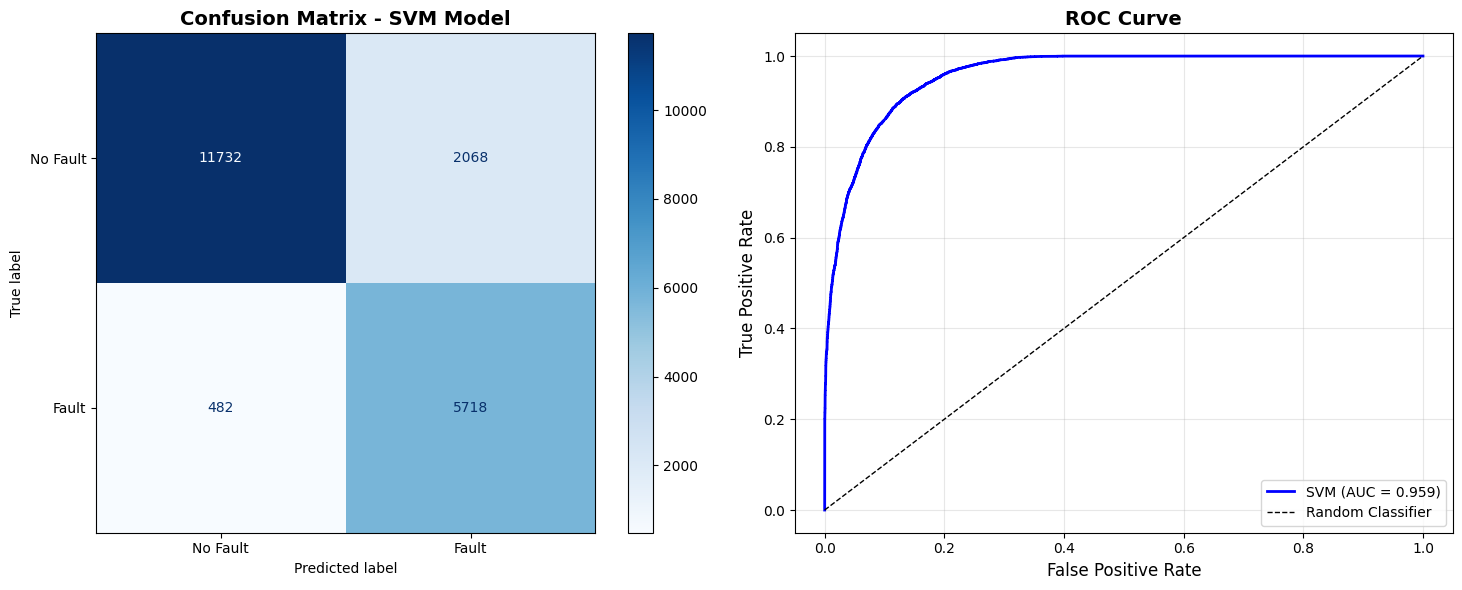

In [3]:
# Create visualization figure
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 1. Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Fault', 'Fault'])
disp.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('Confusion Matrix - SVM Model', fontsize=14, fontweight='bold')

# 2. ROC Curve
axes[1].plot(fpr, tpr, 'b-', linewidth=2, label=f'SVM (AUC = {roc_auc:.3f})')
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
axes[1].set_xlabel('False Positive Rate', fontsize=12)
axes[1].set_ylabel('True Positive Rate', fontsize=12)
axes[1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'svm_confusion_roc.png'), dpi=300, bbox_inches='tight')
plt.show()

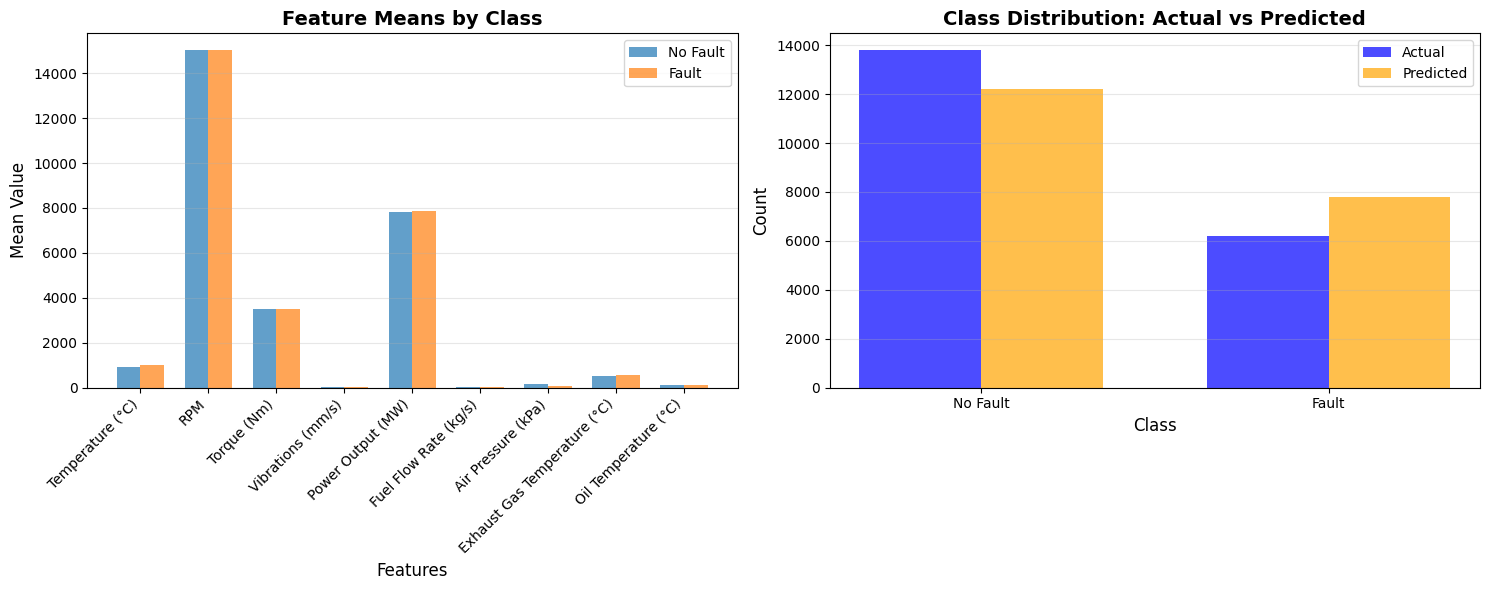

In [ ]:
# For SVM with RBF kernel, we can't directly get feature importance
# But we can use the absolute values of the dual coefficients as an approximation
# Note: This is an approximation and may not be perfectly accurate for RBF kernel

# Get feature importance approximation
# For non-linear kernels, we can look at the magnitude of weights in the transformed space
# or use permutation importance (requires additional computation)

# For now, let's create a simple bar plot of feature means by class
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Feature means comparison
x = np.arange(len(feature_names))
width = 0.35

axes[0].bar(x - width/2, means_class_0, width, label='No Fault', alpha=0.7)
axes[0].bar(x + width/2, means_class_1, width, label='Fault', alpha=0.7)
axes[0].set_xlabel('Features', fontsize=12)
axes[0].set_ylabel('Mean Value', fontsize=12)
axes[0].set_title('Feature Means by Class', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(feature_names, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Plot 2: Prediction distribution

x = np.arange(2)
width = 0.35

axes[1].bar(x - width/2, true_counts.values, width, label='Actual', alpha=0.7, color='blue')
axes[1].bar(x + width/2, pred_counts.values, width, label='Predicted', alpha=0.7, color='orange')
axes[1].set_xlabel('Class', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Class Distribution: Actual vs Predicted', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(['No Fault', 'Fault'])
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'svm_feature_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

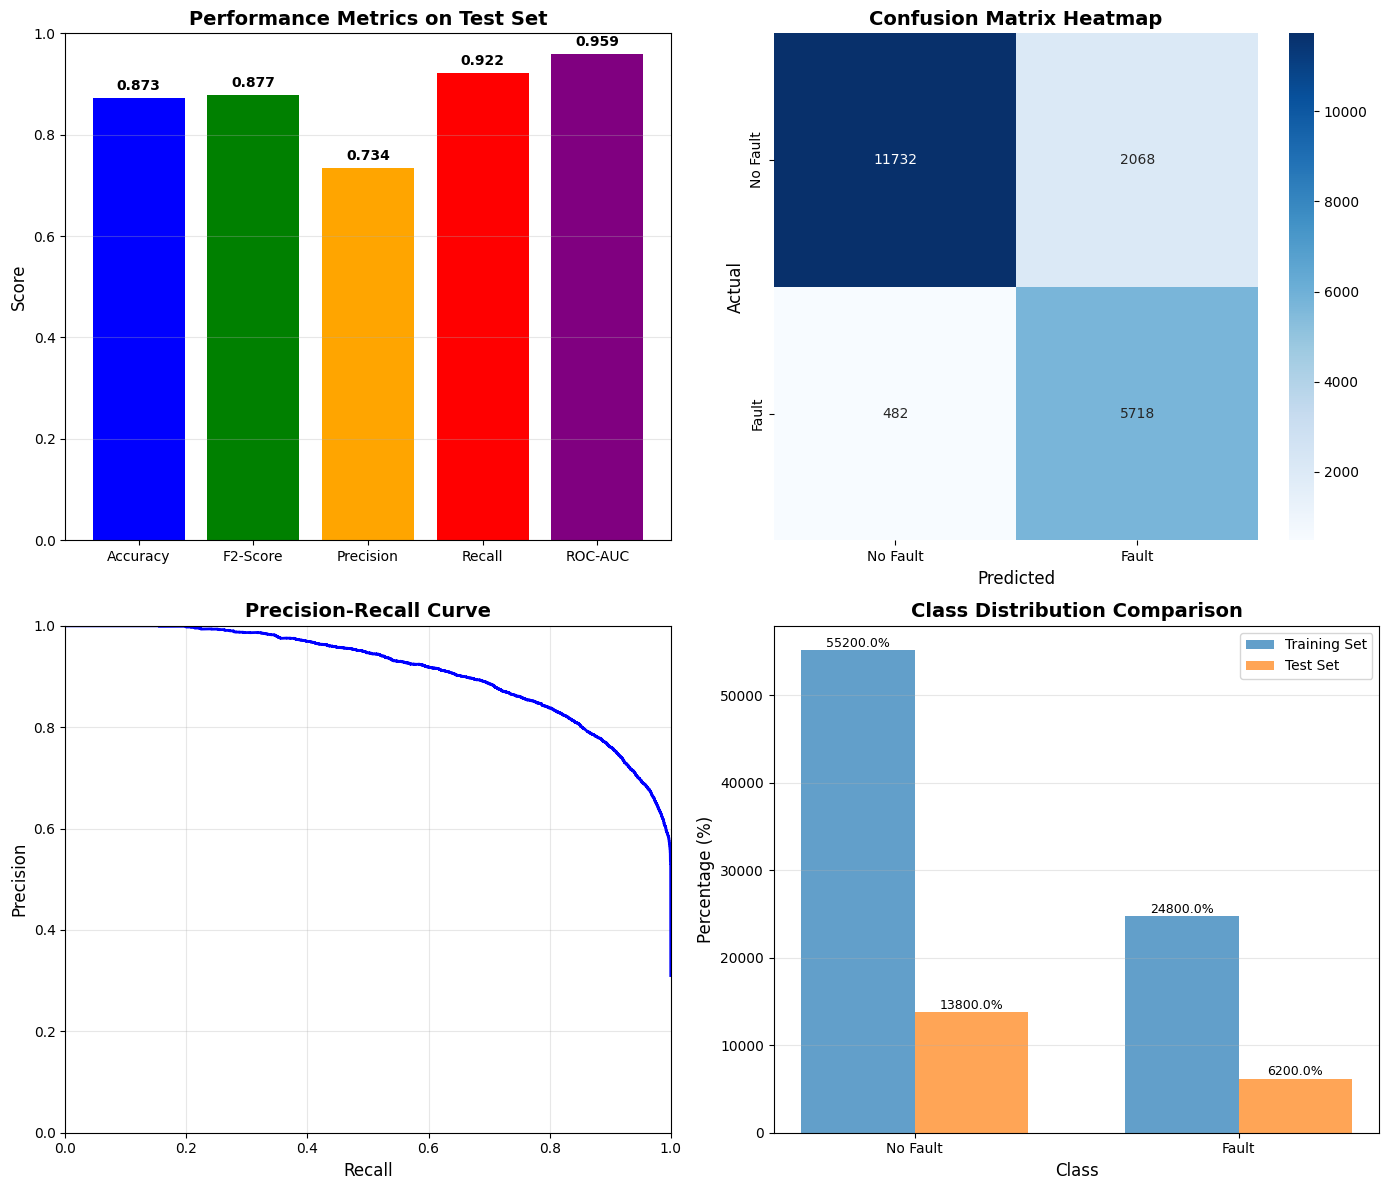

In [ ]:
# Create a comprehensive metrics visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Metrics Bar Chart
metrics_names = ['Accuracy', 'F2-Score', 'Precision', 'Recall', 'ROC-AUC']
metrics_values = [accuracy, f2_score, precision, recall, roc_auc]

bars = axes[0, 0].bar(metrics_names, metrics_values, color=['blue', 'green', 'orange', 'red', 'purple'])
axes[0, 0].set_ylabel('Score', fontsize=12)
axes[0, 0].set_title('Performance Metrics on Test Set', fontsize=14, fontweight='bold')
axes[0, 0].set_ylim(0, 1)
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, value in zip(bars, metrics_values):
    height = bar.get_height()
    axes[0, 0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 2. Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 1],
           xticklabels=['No Fault', 'Fault'],
           yticklabels=['No Fault', 'Fault'])
axes[0, 1].set_xlabel('Predicted', fontsize=12)
axes[0, 1].set_ylabel('Actual', fontsize=12)
axes[0, 1].set_title('Confusion Matrix Heatmap', fontsize=14, fontweight='bold')

# 3. Precision-Recall Curve
axes[1, 0].plot(recall_vals, precision_vals, 'b-', linewidth=2)
axes[1, 0].set_xlabel('Recall', fontsize=12)
axes[1, 0].set_ylabel('Precision', fontsize=12)
axes[1, 0].set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xlim([0, 1])
axes[1, 0].set_ylim([0, 1])

# 4. Class Distribution Comparison
x = np.arange(2)
width = 0.35

bars1 = axes[1, 1].bar(x - width/2, train_dist, width, label='Training Set', alpha=0.7)
bars2 = axes[1, 1].bar(x + width/2, test_dist, width, label='Test Set', alpha=0.7)
axes[1, 1].set_xlabel('Class', fontsize=12)
axes[1, 1].set_ylabel('Percentage (%)', fontsize=12)
axes[1, 1].set_title('Class Distribution Comparison', fontsize=14, fontweight='bold')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(['No Fault', 'Fault'])
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 1,
                       f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'svm_comprehensive_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

In [8]:
# Load the cross-validation results from Optuna study
print("SUMMARY OF RESULTS")
print("="*60)

# Best score from Optuna optimization (from your notebook)
optuna_best_score = 0.8687714818256752
print(f"\nBest Cross-Validation F2-Score (3-fold): {optuna_best_score:.4f}")
print(f"Test Set F2-Score: {f2_score:.4f}")
print(f"Difference: {abs(optuna_best_score - f2_score):.4f}")

# Calculate additional statistics
error_rate = 1 - accuracy
specificity = cm[0,0] / (cm[0,0] + cm[0,1]) if (cm[0,0] + cm[0,1]) > 0 else 0

print(f"\nAdditional Statistics:")
print(f"Error Rate: {error_rate:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Sensitivity (Recall): {recall:.4f}")
print(f"F1-Score: {2 * (precision * recall) / (precision + recall):.4f}")

# Create a comparison table
comparison_data = {
    'Metric': ['F2-Score', 'Accuracy', 'Precision', 'Recall', 'ROC-AUC'],
    'Cross-Validation (Mean)': [optuna_best_score, 'N/A', 'N/A', 'N/A', 'N/A'],
    'Test Set': [f2_score, accuracy, precision, recall, roc_auc]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n" + "="*60)
print("PERFORMANCE COMPARISON")
print("="*60)
print(comparison_df.to_string(index=False))

# Save comparison to CSV
comparison_df.to_csv(os.path.join(results_dir, 'svm_performance_comparison.csv'), index=False)
print(f"\nComparison saved to: {os.path.join(results_dir, 'svm_performance_comparison.csv')}")

SUMMARY OF RESULTS

Best Cross-Validation F2-Score (3-fold): 0.8688
Test Set F2-Score: 0.8774
Difference: 0.0086

Additional Statistics:
Error Rate: 0.1275
Specificity: 0.8501
Sensitivity (Recall): 0.9223
F1-Score: 0.8177

PERFORMANCE COMPARISON
   Metric Cross-Validation (Mean)  Test Set
 F2-Score                0.868771  0.877371
 Accuracy                     N/A  0.872500
Precision                     N/A  0.734395
   Recall                     N/A  0.922258
  ROC-AUC                     N/A  0.958829

Comparison saved to: results/svm_performance_comparison.csv
